Team members: 
* Fatou SALL
* Sebastion COUBE




In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [22]:
import pandas as pd
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import lil_matrix
import seaborn as sns
import networkx as nx
import operator
from networkx.algorithms import community
import plotly
import plotly.graph_objs as go
import plotly.plotly as py
import time
from networkx.drawing.nx_agraph import graphviz_layout
from scipy import linalg, cluster, sparse
from tqdm import tqdm_notebook
from utils import get_bag_of_communities

from utils import load_obj, save_obj

## Introduction

Le clustering sont des outils d'analyse des données qui permettent de grouper des échantillons, de sorte que les membres d'un même groupe (ou *cluster*) sont très similaires, alors que ceux de groupes différents ne le sont pas. Dans la suite, nous allons préciser explorer Clustering Spectral. 

>-Soit $G = (V,E)$ un graphe non orienté avec $V$ l'ensemble des sommets et $E$ l'ensemble des arrets avec un poid non negative $w_{ij} ≥ 0$.


>-La matrice adjacente du graphe $G$ est la matrice $W = (w_{ij})$ $i,j=1,...,n$.

>-Le degrée d'un sommet $v_i \in V$ est defini par $d_i = \sum\limits_{j=1}^n w_{ij}$.

>-Le degrée matricielle $D$ est défini par une matrice diagonale ayant pour diagonales les degrées $d_1, . . . , d_n$.

### Graphe de similitude
Il y a plusieurs façon de transformer un ensemble donné de points $x_1, . . . , x_n$ doté d'une matrice de similarités $s_{ij}$ ou d'une matrice de distance $d_{ij}$ en un graphe. Lorsque l'on construit un graphe de similitude, le but est de modéliser la relation de voisin proche entre les points.

- Le ε-voisinage graphe : On connecte tous les points dont la distance l'un l'autre est plus petite que ε.

- Le k-plus proche voisin graphe : Ici le but est de connecter $v_i$ avec le sommet $v_j$ if $v_j$ est parmi les k-plus proches voisins de $v_i$ mais comme la relation de voisin n'est pas forcément symetrique, on considère deux différentes constructions.

    - Le k-plus proche voisin graphe : On ignore les directions des arêtes, on connecte $v_i$ et $v_j$ avec une arête non orientée si $v_i$ est parmi les k-plus proches voisins de $v_j$ ou si $v_j$ est parmi les k-plus proches voisins de $v_i$.
    - Le mutuel k-plus proche voisin graphe : On connecte les sommets $v_i$ et $v_j$ si on a $v_i$ est parmi les k-plus proches voisins de $v_j$ et si $v_j$ est parmi les k-plus proches voisins de $v_i$.

-Le graphe complet : Ici on connecte simplement l'ensemble des points avec une similaritée positive, le poids de chaque arête étant $s_{ij}$.


### Graphe Laplaciens et leurs propriétés basiques
La matrice du graphe Laplacien non normalisé est défini par $L = D − W$.


### Spectral clustering non normalisé
Our algorithm has been previously described in (Ng et al, 2002). Provided a set of points $S= {s_1,...,s_n}$ in $\mathbb{R}^l$ that we want to clsuter into $k$ subsets:

> $1.$ Define the affinity matrix $A \in \mathbb{R}^{nxn}$ by $A_{ij}=exp(-||s_i-s_j||^2 / 2\sigma^2)$ if $i\neq{j}$, and $A_{ii}=0$.
    
    
> $2.$ Create a diagonal matrix whose ($i$,$i$) element is the sum of $A's$ i-th row, and construct L, where $L= D^{-1/2}AD^{-1/2}$.
    
    
> $3.$ Find ${x_1,...,x_n}$, the $k$ largest eigenvectors of $L$, which are chosen to be orthogonal to one another in the chance there are repeated eigenvalues. Then create the matrix $X$, by placing the k eigenvectors in columns.
    
    
> $4.$ Use $X$ to form the matrix $Y$, by normalizing each X's rows to have unit length (i.e. $Y_{ij}=X_{ij}/(\sum_{j}{}X_{ij}^2)^{1/2}$). 
    
    
> $5.$ Treating each row of $Y$ as a point in $\mathbb{R}^k$, cluster into $k$ clusters using K-means
    
    
> $6.$ Assign the original point $s_i$ to cluster $j$ if row $i$ of the matrix $Y$ was assigned to cluster $j$. 



###  Spectral clustering normalisé
Our algorithm has been previously described in (Ng et al, 2002). Provided a set of points $S= {s_1,...,s_n}$ in $\mathbb{R}^l$ that we want to clsuter into $k$ subsets:

> $1.$ Define the affinity matrix $A \in \mathbb{R}^{nxn}$ by $A_{ij}=exp(-||s_i-s_j||^2 / 2\sigma^2)$ if $i\neq{j}$, and $A_{ii}=0$.
    
    
> $2.$ Create a diagonal matrix whose ($i$,$i$) element is the sum of $A's$ i-th row, and construct L, where $L= D^{-1/2}AD^{-1/2}$.
    
    
> $3.$ Find ${x_1,...,x_n}$, the $k$ largest eigenvectors of $L$, which are chosen to be orthogonal to one another in the chance there are repeated eigenvalues. Then create the matrix $X$, by placing the k eigenvectors in columns.
    
    
> $4.$ Use $X$ to form the matrix $Y$, by normalizing each X's rows to have unit length (i.e. $Y_{ij}=X_{ij}/(\sum_{j}{}X_{ij}^2)^{1/2}$). 
    
    
> $5.$ Treating each row of $Y$ as a point in $\mathbb{R}^k$, cluster into $k$ clusters using K-means
    
    
> $6.$ Assign the original point $s_i$ to cluster $j$ if row $i$ of the matrix $Y$ was assigned to cluster $j$. 





## Algorithme

### Etape 1  : Calcul du laplacien

In [4]:
def diag_matrice_degre(w):
    #print("0-Calcul de la matrice dégré d ..................... ")
    
    return np.diag(np.sum(w,axis=1))


def laplacien(w):
    #print("1-Calcul du laplacien ..................... ")
    return diag_matrice_degre(w)-w   

### Etape 2 : Calcul des k vecteurs associés aux k plus petites valeurs propres du laplacien

In [5]:
def k_vector_propre(L,k): 
    #print("2-Calcul des {} vecteurs associés aux {} plus petites valeurs propres du laplacien ..................... ".format(k,k))
    eigenvalues, eigenvectors = np.linalg.eig(L)
    sorted_index = np.argsort(eigenvalues)
    eigenvectors=np.array(eigenvectors)
    plt.plot(eigenvalues, '.-', markersize=15)
    plt.imshow
    return eigenvectors[:,sorted_index[0:k]]
    


### Etape 3  : Partitionnement des vecteurs propres en avec kmeans

In [21]:
def spectralClustering(w,k,normalise=False):
    #print("3-Partitionnement des vecteurs propres en avec kmeans ..................... ")
    if normalise:
        L = np.sqrt(D).dot(A).dot(np.sqrt(D)) 
        x= k_vector_propre(L,k)
        Y = X / np.sum(X, 1)[:, np.newaxis]
        return Kmeans(Y,k)
    else:
        L=laplacien(w)
        Y=k_vector_propre(L,k) 
        return Kmeans(Y,k)

def initialize(X,K):
     #print('Initialisation .....................\n ')
    centers = X[random.sample(range(0,(X.shape[0]-1)),K)]
    return centers

def assignment(X, centers):
    indx = []
    for point in X:
        norm = np.linalg.norm((centers-point), axis =1)
        indx.append(np.argmin(norm))
    return indx

def updateCenters(X,K,indx):

    newCenters = []
    for clusterNumber in range(0,K):
        Cluster = X[[i for i, find in enumerate(indx) if find == clusterNumber]]
        centroid = Cluster.mean(axis=0)
        newCenters.append(centroid)
    return newCenters

def AvgScore(X,K,indx,centers):
    score = []
    for clusterNumber in range(0,K):
        Cluster = X[[i for i, find in enumerate(indx) if find == clusterNumber]]
        distanceList = np.linalg.norm((Cluster-centers[clusterNumber]), axis =1)
        score.append(np.mean(distanceList))
            
    return score



def Kmeans(X,K,tol=0.0001,plot=False,stat=False):
    X = np.array(X)
    centers = initialize(X,K)
    indx = assignment(X, centers)
    AvgScore(X,K,indx,centers)
    Distortion = 1
    #print('Mis à jours des clusters .....................\n ')
    while Distortion > tol:
        newCenters = updateCenters(X,K,indx)
        newIndx = assignment(X, newCenters)
        
        scoreOld = AvgScore(X,K,indx,centers)
        scoreNew = AvgScore(X,K,newIndx,newCenters)
        
        Distortion = np.linalg.norm((np.array(scoreOld) - np.array(scoreNew)), axis =0)
        centers = newCenters
        indx = newIndx
        if stat:
            print('Score Old:',scoreOld,'\n')
            print('Score new:',scoreNew,'\n')
            print('Distortion:', Distortion)
            print('---------------------')
        
    if plot:
        DisplayPlot(X,K,centers,indx)
        
    return centers, indx, scoreNew

In [7]:
def DisplayPlot(X,K,centers,indx):
    colors = ['green', 'purple', 'yellow', 'red', 'orange', 'plum', 'navy', 'seagreen', 'pink', 'brown']
    for clusterNumber in range(0,K):
        Cluster = X[[i for i, find in enumerate(indx) if find == clusterNumber]]
        plt.scatter(Cluster[:,0],Cluster[:,1], marker='.' ,color=colors[clusterNumber])
        plt.scatter(np.array(centers)[clusterNumber,0],np.array(centers)[clusterNumber,1], marker='+' ,color='black')    
    plt.show()

In [18]:
def partitions(spectral_partition):
    partition = {}
    for i in range(k):
        comp=[]
        for title,labels in spectral_partition.items():
            if i==labels:
                comp.append(title)   
        partition[i]=set(comp)
    return list(partition.values())

## Application:

### Données simulées

In [8]:

from sklearn import cluster, datasets
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)
df = pd.DataFrame(noisy_moons[0]) ## convert to DF



#### Génération d'une matrice poids adjacente

In [9]:
def matrice_adjacente(X,gamma):
    n=X.shape[0]
    a=np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            a[i,j] = math.exp(-math.pow(np.linalg.norm((X[i]-X[j]),2),2) * gamma)
    return a
def construct_W(X, Wtemp, k_neighbors):
    scores_matrix = lil_matrix(Wtemp)
    # knn_matrix is a sparse matrix
    knn_matrix = kneighbors_graph(X, k_neighbors, mode='connectivity', include_self=True)
    W = knn_matrix.multiply(scores_matrix)  # pointwise multiply
    return W.toarray()

#### Visualisation des données

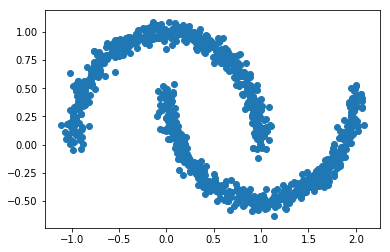

In [10]:


import matplotlib.pyplot as plt
plt.scatter(df[0],df[1])
plt.show()

 #### Détection de communauté:

C:\Anacond\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning:

Casting complex values to real discards the imaginary part



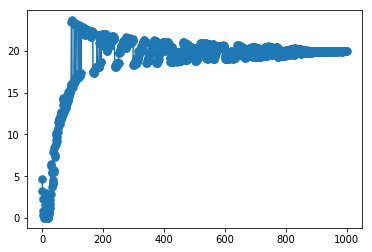

In [12]:
X = np.array(df)
A = matrice_adjacente(X,1)
w = construct_W(X,A,20)
centers_sim, indx_sim, score_sim = spectralClustering(w,2)


#### Visualition des communautés trouvées

C:\Anacond\lib\site-packages\numpy\core\numeric.py:544: ComplexWarning:

Casting complex values to real discards the imaginary part



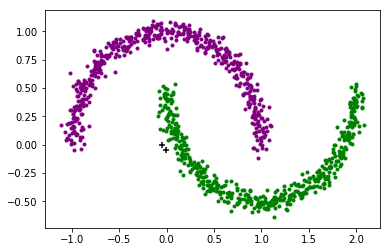

In [13]:
DisplayPlot(np.array(df),2,centers_sim,indx_sim)

### Application sur les données de Wikipedia

#### Parsing des données

In [ ]:
from utils import explore_page

In [ ]:
root_node = 'Jaguar (disambiguation)'

network = {}  # This dict stores for each page a dictionnary containing the keys [url, links, categories]
first_nodes = []

explore_page(root_node, network, first_nodes)

second_nodes = []
for node in first_nodes:
    explore_page(node, network, second_nodes)

In [ ]:
all_nodes = list(network.keys()) + second_nodes
for link in tqdm_notebook(second_nodes):
    explore_page(link, network, [], inner=True, all_nodes=all_nodes)

In [ ]:
all_nodes = list(network.keys())
for title in tqdm_notebook(network.keys()):
    network[title]['links'] = list(set(network[title]['links']).intersection(set(all_nodes)))

In [ ]:


l = list(network.keys())
for i in l:
    if len(network[i]['links']) == 0:
        del network[i]



In [ ]:
for i, title in enumerate(network.keys()):
    cats = network[title]['categories']
    new_cats = []
    for c in cats:
        if not c.startswith('Redundant') and not c.startswith('Pages') and not c.startswith('Webarchive') and not c.startswith('Wikipedia') and not c.startswith('Articles') and not c.startswith('Coordinates on Wikidata') and not 'Wikidata' in c and not c.startswith('CS1') and not c.startswith('EngvarB') and not c.startswith('All') and not c.startswith('Good articles') and not c.startswith('Use dmy'):
            new_cats.append(c)
    network[title]['categories'] = new_cats

#### Création des graphes

In [8]:
# save_obj(network, 'network')
network = load_obj('network')

In [9]:
neighbors = {}
for i in network.keys():
    neighbors[i] = network[i]['links']

In [10]:
g = nx.Graph(neighbors)  # undirected graph

In [11]:
print('Total number of nodes : {}'.format(len(g.nodes)))
print('Total number of edges : {}'.format(len(g.edges)))
if nx.is_connected(g):
    print('The graph is connected.')
else:
    print('The graph is not connected.')

Total number of nodes : 6830
Total number of edges : 367483
The graph is connected.


In [12]:
w = nx.adjacency_matrix(g)
w.shape

(6830, 6830)

In [13]:
def matrice_adjacente(X):
    return nx.adjacency_matrix(X)

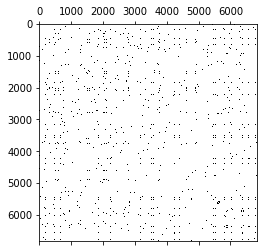

In [15]:

plt.spy(w.todense())


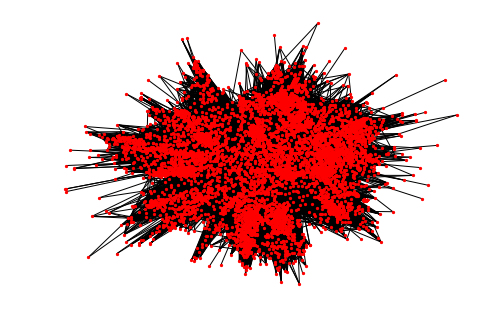

In [23]:
nx.draw(g, node_size=5, figsize=(15, 15))

#### Détection des communautés

C:\Anacond\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning:

Casting complex values to real discards the imaginary part



--- 221.94256925582886 seconds ---


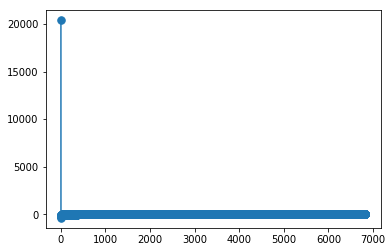

In [23]:
k=2
w = nx.adjacency_matrix(g)
start_time = time.time()
centroid_ , labels, score = spectralClustering(w,k)
print("--- %s seconds ---" % (time.time() - start_time))

In [27]:
spectral_partition = {}
for i, title in enumerate(network.keys()):
    #print(title)
    spectral_partition[title] = labels[i]


spectral_bag = get_bag_of_communities(network, spectral_partition)


spectral_counts = [0 for _ in range(k)]
for i, title in enumerate(spectral_partition.keys()):
    spectral_counts[spectral_partition[title]] += 1



for i in range(k):
    sorted_bag = sorted(spectral_bag[i].items(), key=operator.itemgetter(1), reverse=True)
    print(' ')
    print('Communauté {}/{} ({} pages) : '.format(i+1, k, spectral_counts[i]))
    if spectral_counts[i] > 0:
        for ind in range(10):
            print(sorted_bag[ind])

In [26]:
normal=[True, False]

#### Validation croisée pour le k optimal

In [ ]:
for norm in normal:
    normalise=norm
    cross_val_modularity = {}
    cross_val_performance = {}
    for k in tqdm_notebook(range(10, 30)):
        print(k)
        tmp_modularity = []
        tmp_performance= []
        for _ in range(5):
            centroid , labels, score = spectralClustering(w,k)
            spectral_partition = {}
            for i, title in enumerate(network.keys()):
                spectral_partition[title] = labels[i]
            partition=partitions(spectral_partition)
            spectral_modularity = community.modularity(g,partition)
            spectral_performance = community.performance(g,partition)
            tmp_modularity.append(spectral_modularity)
            tmp_performance.append(spectral_modularity)
        cross_val_modularity[k] = [np.mean(tmp_modularity), np.std(tmp_modularity)]
        cross_val_performance[k] = [np.mean(tmp_performance), np.std(tmp_performance)]
    save_obj(cross_val_modularity, 'cross_val_modularity_{}'.format(norm))
    save_obj(cross_val_performance, 'cross_val_performance_{}'.format(norm))    

G = nx.karate_club_graph()
p = community.best_partition(G, weight='weight')
print(p)

#### Visualition des communautés

In [28]:
community2color = {
    0: sns.xkcd_rgb["peach"],
    1: sns.xkcd_rgb["powder blue"],
    2: sns.xkcd_rgb["light pink"],
    3: sns.xkcd_rgb["chocolate"],
    4: sns.xkcd_rgb["orange"],
    5: sns.xkcd_rgb["magenta"],
    6: sns.xkcd_rgb["purple"],
    7: sns.xkcd_rgb["blue"],
    8: sns.xkcd_rgb["deep blue"],
    9: sns.xkcd_rgb["sky blue"],
    10: sns.xkcd_rgb["olive"],
    11: sns.xkcd_rgb["seafoam green"],
    12: sns.xkcd_rgb["tan"],
    13: sns.xkcd_rgb["mauve"],
    14: sns.xkcd_rgb["hot pink"],
    15: sns.xkcd_rgb["pale green"],
    16: sns.xkcd_rgb["indigo"],
    17: sns.xkcd_rgb["lavender"],
    18: sns.xkcd_rgb["eggplant"],
    19: sns.xkcd_rgb["brick"],
    20: sns.xkcd_rgb["light blue"],
}

In [29]:
position = nx.spring_layout(g)

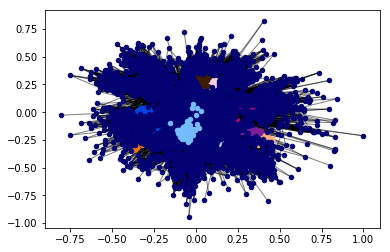

In [30]:


for community in set(spectral_partition.values()) :
    list_nodes = [nodes for nodes in spectral_partition.keys() if spectral_partition[nodes] == community]
    nx.draw_networkx_nodes(g, position, list_nodes, node_size=20, node_color=community2color[int(community)])

nx.draw_networkx_edges(g, position, alpha=0.5)
plt.show()



In [31]:
for i in spectral_partition.keys():
    spectral_partition[i] = str(spectral_partition[i])

In [32]:
nx.set_node_attributes(g, spectral_partition, 'spectral')

In [33]:
nx.write_graphml(g, 'data/full_graph.graphml')

## References

**[2]** von Luxburg, U., A Tutorial on Spectral Clustering, in *Statistics and Computing*, 17 (4), 2007.

